In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.signal import savgol_filter
import re
import glob
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [127]:
def extract_experiment_info(filepath):
    """Extract experiment name and type (train/test) from filepath"""
    path = Path(filepath)
    parts = path.parts
    
    # Extract experiment identifier from path
    exp_folder = None
    for part in parts:
        if part.startswith('250'):  # Date pattern
            exp_folder = part
            break
    
    if exp_folder:
        # Extract experiment name (everything after the date and time)
        match = re.search(r'250\d{3}_\d{4}_([^_]+)', exp_folder)
        if match:
            exp_name = match.group(1)
        else:
            exp_name = exp_folder
    else:
        exp_name = "unknown"
    
    # Determine if train or test
    data_type = "train" if "train" in path.name else "test"
    
    return exp_name, data_type

def smooth_data(y, method='ema', window=21, poly=3, alpha=0.1):
    """Apply smoothing to data"""
    if len(y) < window:
        window = max(3, len(y) // 3)
        if window % 2 == 0:
            window += 1
    
    if method == 'savgol':
        if len(y) >= window:
            return savgol_filter(y, window, poly)
        else:
            return y
    elif method == 'ema':
        # Exponential moving average
        smoothed = np.zeros_like(y)
        smoothed[0] = y[0]
        for i in range(1, len(y)):
            smoothed[i] = alpha * y[i] + (1 - alpha) * smoothed[i-1]
        return smoothed
    else:
        # Simple moving average
        return np.convolve(y, np.ones(window)/window, mode='same')

def load_and_process_data(file_paths):
    """Load all CSV files and organize data by experiment and type"""
    all_data = {}
    
    for filepath in file_paths:
        try:
            # Read CSV file
            df = pd.read_csv(filepath)
            
            # Clean column names (remove whitespace)
            df.columns = df.columns.str.strip()
            
            # Extract experiment info
            exp_name, data_type = extract_experiment_info(filepath)
            
            # Create experiment key
            exp_key = f"{exp_name}_{data_type}"
            
            # Store data
            all_data[exp_key] = df
            
            print(f"Loaded {filepath}: {len(df)} rows, columns: {list(df.columns)}")
            
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    return all_data


import numpy as np
import matplotlib.pyplot as plt

def plot_single_experiment_difference(all_data, exp_name, metrics=['ema_vs_gt',"pl_vs_gt"], smoothing_method='ema', figsize=(16, 10)):
    """Plot train/test metrics and differences for a single experiment."""

    train_key = f"{exp_name}_train"
    test_key = f"{exp_name}_test"
    
    # Check if experiment exists
    if train_key not in all_data or test_key not in all_data:
        print(f"Error: Experiment '{exp_name}' not found in data.")
        available_exps = set(key.replace('_train', '').replace('_test', '') for key in all_data.keys())
        print(f"Available experiments: {sorted(available_exps)}")
        return None, None
    
    train_df = all_data[train_key]
    test_df = all_data[test_key]
    
    # --- Train data ---
    ema_train = train_df[metrics[0]].dropna().values
    pl_train  = train_df[metrics[1]].dropna().values
    diff_train = ema_train - pl_train

    ema_train_smooth = smooth_data(ema_train, method=smoothing_method)
    pl_train_smooth  = smooth_data(pl_train, method=smoothing_method)
    diff_train_smooth = smooth_data(diff_train, method=smoothing_method)
    
    # --- Test data ---
    ema_test = test_df[metrics[0]].dropna().values
    pl_test  = test_df[metrics[1]].dropna().values
    diff_test = ema_test - pl_test

    ema_test_smooth = smooth_data(ema_test, method=smoothing_method)
    pl_test_smooth  = smooth_data(pl_test, method=smoothing_method)
    diff_test_smooth = smooth_data(diff_test, method=smoothing_method)
    
    # X-axis (take min length to avoid mismatch)
    min_len = min(len(ema_train), len(pl_train), len(ema_test), len(pl_test))
    x = np.arange(min_len)

    # --- Create subplots (2x2 grid) ---
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)

    # (0,0) Train metrics
    axes[0,0].plot(x, ema_train_smooth[:min_len], label="EMA vs GT (smoothed)", color="blue", linewidth=2)
    axes[0,0].plot(x, pl_train_smooth[:min_len], label="PL vs GT (smoothed)", color="green", linewidth=2)
    axes[0,0].plot(x, ema_train[:min_len], alpha=0.3, color="blue", linewidth=0.5)
    axes[0,0].plot(x, pl_train[:min_len], alpha=0.3, color="green", linewidth=0.5)
    axes[0,0].set_title(f"{exp_name} - Source Metrics", fontsize=13, fontweight="bold")
    axes[0,0].set_ylabel("IoU Score")
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)
    axes[0,0].set_ylim(0, 1)

    # (0,1) Train difference
    axes[0,1].plot(x, diff_train_smooth[:min_len], label="Signed Diff (smoothed)", color="purple", linewidth=2)
    axes[0,1].plot(x, diff_train[:min_len], alpha=0.3, color="purple", linewidth=0.5)
    axes[0,1].axhline(0, color="black", linestyle="--", alpha=0.5)
    axes[0,1].axhline(np.mean(diff_train), color="red", linestyle="--", alpha=0.7, label=f"Mean: {np.mean(diff_train):.4f}")
    axes[0,1].set_title(f"{exp_name} - Source Difference", fontsize=13, fontweight="bold")
    axes[0,1].legend()
    axes[0,1].grid(alpha=0.3)

    # (1,0) Test metrics
    axes[1,0].plot(x, ema_test_smooth[:min_len], label="EMA vs GT (smoothed)", color="blue", linewidth=2)
    axes[1,0].plot(x, pl_test_smooth[:min_len], label="PL vs GT (smoothed)", color="green", linewidth=2)
    axes[1,0].plot(x, ema_test[:min_len], alpha=0.3, color="blue", linewidth=0.5)
    axes[1,0].plot(x, pl_test[:min_len], alpha=0.3, color="green", linewidth=0.5)
    axes[1,0].set_title(f"{exp_name} - Cible Metrics", fontsize=13, fontweight="bold")
    axes[1,0].set_ylabel("IoU Score")
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)
    axes[1,0].set_ylim(0, 1)

    # (1,1) Test difference
    axes[1,1].plot(x, diff_test_smooth[:min_len], label="Signed Diff (smoothed)", color="purple", linewidth=2)
    axes[1,1].plot(x, diff_test[:min_len], alpha=0.3, color="purple", linewidth=0.5)
    axes[1,1].axhline(0, color="black", linestyle="--", alpha=0.5)
    axes[1,1].axhline(np.mean(diff_test), color="red", linestyle="--", alpha=0.7, label=f"Mean: {np.mean(diff_test):.4f}")
    axes[1,1].set_title(f"{exp_name} - Cible Difference", fontsize=13, fontweight="bold")
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)

    for ax in axes[1,:]:
        ax.set_xlabel("Iteration")

    plt.tight_layout()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_experiment_metrics(all_data, exp_name, metrics=["ema_vs_pl", "sam_vs_pl"], 
                            smoothing_method="ema", figsize=(14, 6)):
    """
    Plot two metrics (ema_vs_pl vs sam_vs_pl) for a single experiment
    on both source (train) and target (test), with iteration color coding.
    X-axis = ema_vs_pl, Y-axis = sam_vs_pl
    """

    train_key = f"{exp_name}_train"
    test_key = f"{exp_name}_test"

    # Check if experiment exists
    if train_key not in all_data or test_key not in all_data:
        print(f"Error: Experiment '{exp_name}' not found in data.")
        available_exps = set(key.replace('_train', '').replace('_test', '') for key in all_data.keys())
        print(f"Available experiments: {sorted(available_exps)}")
        return None, None

    train_df = all_data[train_key]
    test_df = all_data[test_key]
    
    # --- Train data ---
    ema_train = train_df[metrics[0]].dropna().values
    ema_train = smooth_data(ema_train, method=smoothing_method)
    sam_train = train_df[metrics[1]].dropna().values
    sam_train = smooth_data(sam_train, method=smoothing_method)

    # --- Test data ---
    ema_test = test_df[metrics[0]].dropna().values
    ema_test = smooth_data(ema_test, method=smoothing_method)
    sam_test = test_df[metrics[1]].dropna().values
    sam_test = smooth_data(sam_test, method=smoothing_method)

    # X-axis (iterations)
    min_len = min(len(ema_train), len(sam_train), len(ema_test), len(sam_test))
    ema_train, sam_train = ema_train[:min_len], sam_train[:min_len]
    ema_test, sam_test   = ema_test[:min_len], sam_test[:min_len]

    iterations = np.arange(min_len)
    cmap = cm.viridis
    colors = cmap(np.linspace(0, 1, min_len))

    # --- Create subplots ---
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

    # Train scatter plot
    axes[0].scatter(ema_train, sam_train, c=colors, s=10)
    axes[0].set_title(f"{exp_name} - Source ", fontsize=13, fontweight="bold")
    axes[0].set_xlabel(metrics[0])
    axes[0].set_ylabel(metrics[1])
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)

    # Test scatter plot
    axes[1].scatter(ema_test, sam_test, c=colors, s=10)
    axes[1].set_title(f"{exp_name} - Cible", fontsize=13, fontweight="bold")
    axes[1].set_xlabel(metrics[0])
    axes[1].set_ylabel(metrics[1])
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)

    # Shared colorbar for iteration coding
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=min_len))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Iteration", fontsize=12)

    plt.show()



In [21]:
file_paths = glob.glob(os.path.join("work_dirs/local-basic","**","*.csv"),recursive=True)

In [22]:
# Load and process all data
print("Loading IoU log files...")
all_data = load_and_process_data(file_paths)

# Print summary
#print_data_summary(all_data)

# Create plots
#print("\nCreating visualization plots...")
#create_summary_plots(all_data, smoothing_method='savgol')

Loading IoU log files...
Loaded work_dirs/local-basic/250818_1047_weihtoi3_6da4d/train_iou_log_final.csv: 5535 rows, columns: ['iteration', 'ema_vs_gt', 'sam_vs_gt', 'pl_vs_gt', 'ema_vs_pl', 'sam_vs_pl']
Loaded work_dirs/local-basic/250818_1047_weihtoi3_6da4d/test_iou_log_final.csv: 19202 rows, columns: ['iteration', 'ema_vs_gt', 'sam_vs_gt', 'pl_vs_gt', 'ema_vs_pl', 'sam_vs_pl']
Loaded work_dirs/local-basic/250820_0428_lw4toweih_ff0a0/train_iou_log_final.csv: 1563 rows, columns: ['iteration', 'ema_vs_gt', 'sam_vs_gt', 'pl_vs_gt', 'ema_vs_pl', 'sam_vs_pl']
Loaded work_dirs/local-basic/250820_0428_lw4toweih_ff0a0/test_iou_log_final.csv: 1563 rows, columns: ['iteration', 'ema_vs_gt', 'sam_vs_gt', 'pl_vs_gt', 'ema_vs_pl', 'sam_vs_pl']
Loaded work_dirs/local-basic/250818_1047_lw4toi3_7e01f/train_iou_log_final.csv: 5156 rows, columns: ['iteration', 'ema_vs_gt', 'sam_vs_gt', 'pl_vs_gt', 'ema_vs_pl', 'sam_vs_pl']
Loaded work_dirs/local-basic/250818_1047_lw4toi3_7e01f/test_iou_log_final.csv: 1

In [23]:
['weihtoi3','weihtolw4', 'lw4toweih','lw4toi3', 'i3toweih']

['weihtoi3', 'weihtolw4', 'lw4toweih', 'lw4toi3', 'i3toweih']

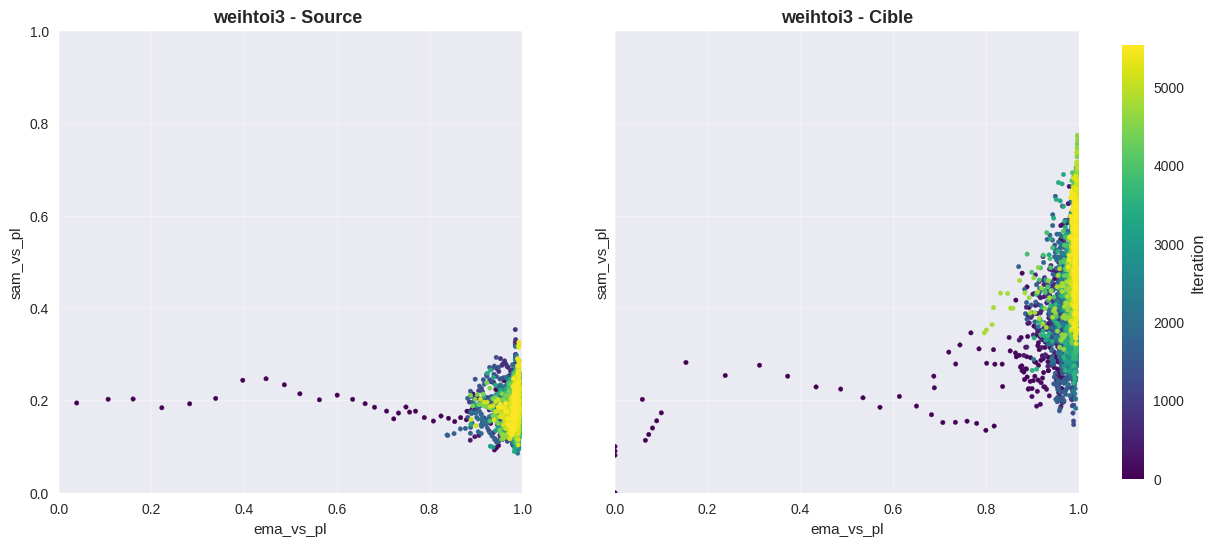

In [128]:
plot_experiment_metrics(all_data,"weihtoi3")

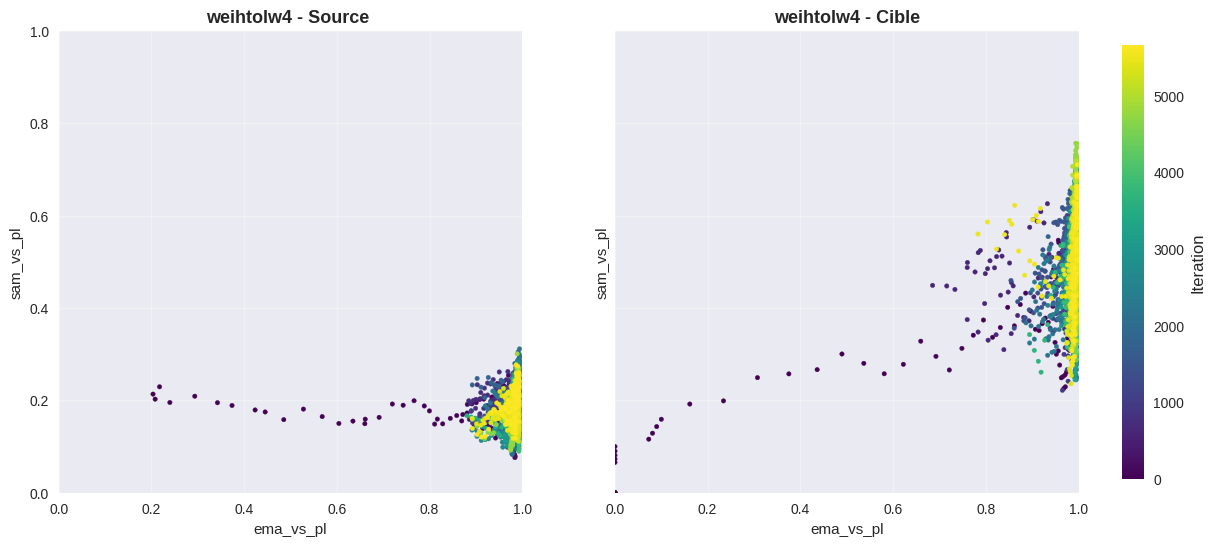

In [129]:
plot_experiment_metrics(all_data,"weihtolw4")

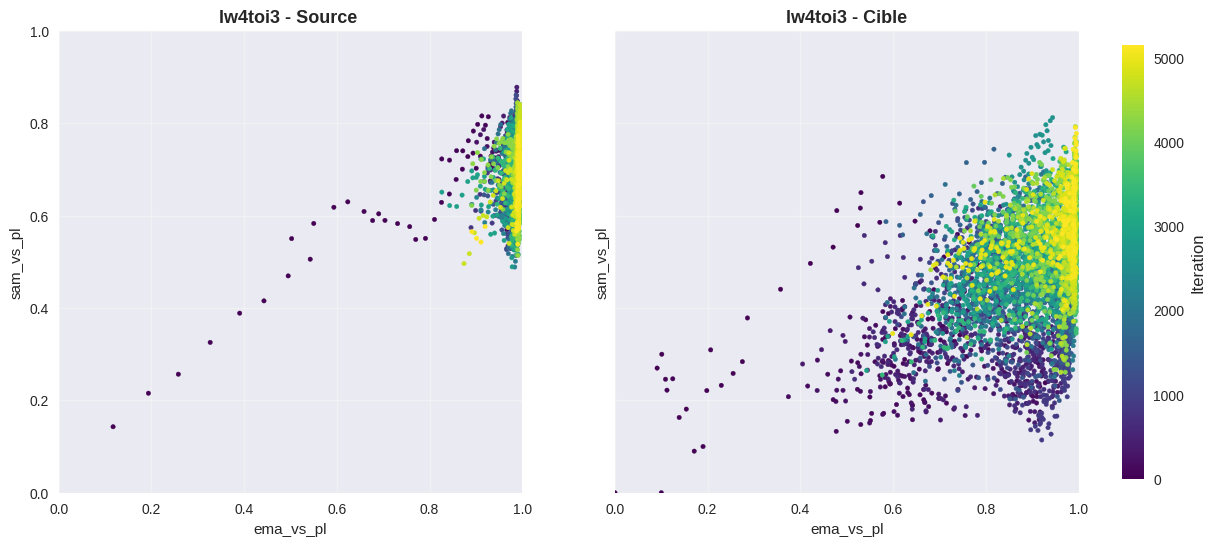

In [130]:
plot_experiment_metrics(all_data,"lw4toi3")

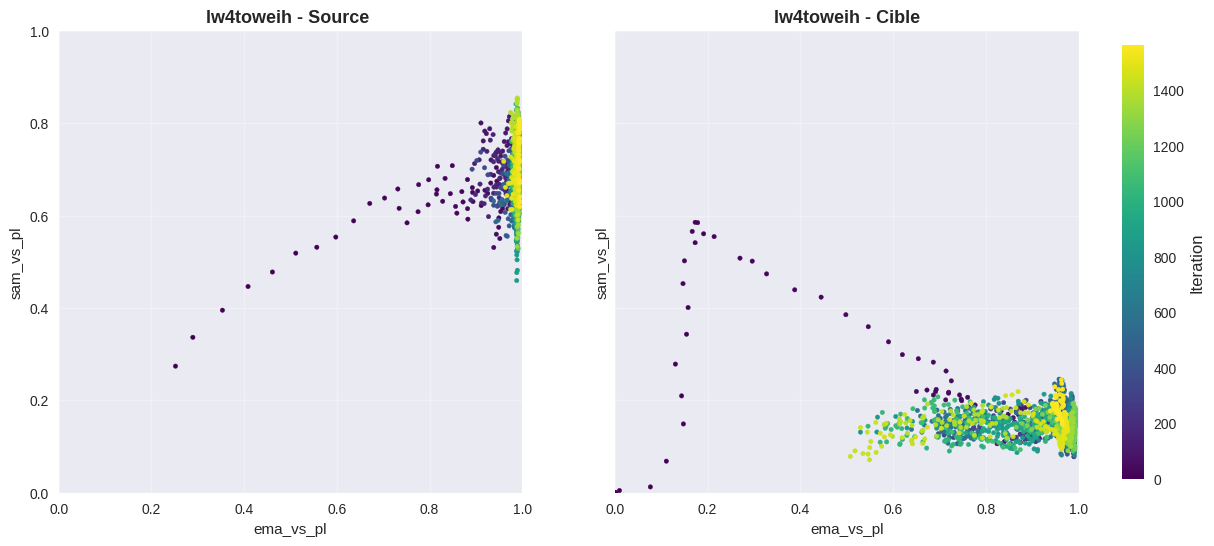

In [133]:
plot_experiment_metrics(all_data,"lw4toweih")

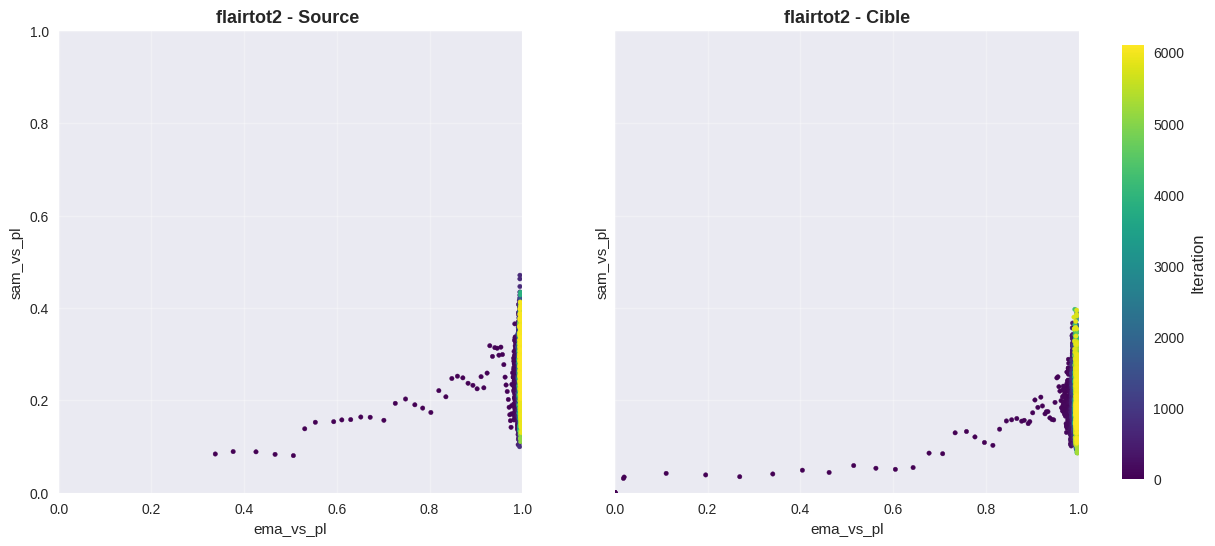

In [132]:
plot_experiment_metrics(all_data,"flairtot2")

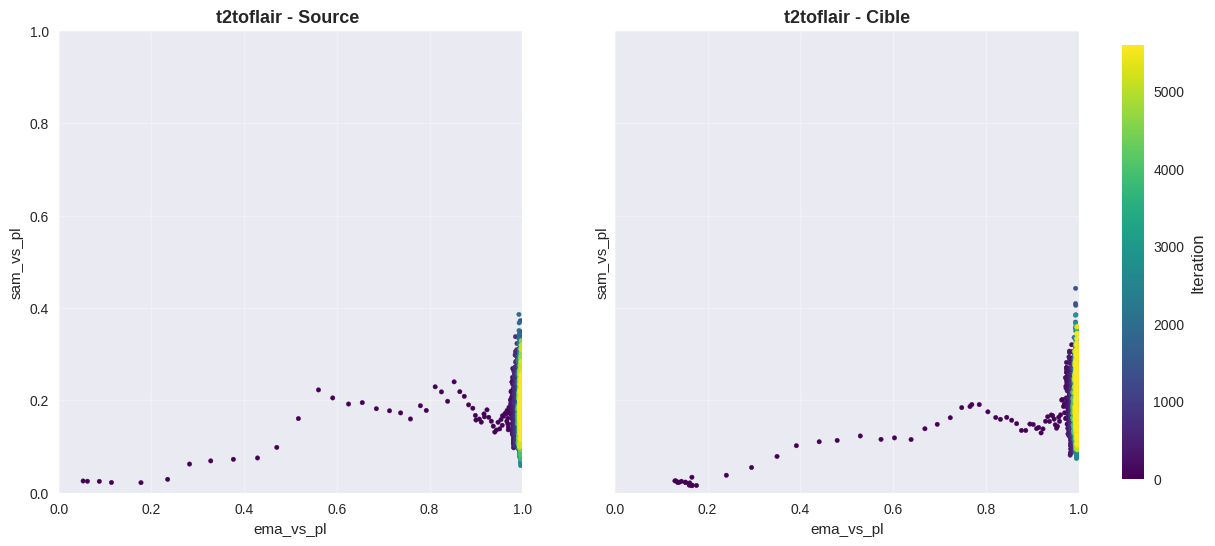

In [134]:
plot_experiment_metrics(all_data,"t2toflair")